# Diagnóstico de Errores del Clasificador

## Objetivo
Identificar **POR QUÉ** el modelo clasifica mal el 30-40% de las veces en producción.

## Hipótesis a investigar:
1. ❓ **Desajuste de dominio**: Imágenes de entrenamiento vs recortes de YOLO
2. ❓ **Tamaño de imagen**: 32x32 es muy pequeño y pierde detalles
3. ❓ **Variabilidad insuficiente**: Faltan ángulos, iluminaciones, contextos
4. ❓ **Calidad de recortes YOLO**: Bounding boxes imprecisos
5. ❓ **Confusión entre clases específicas**: ¿Qué clases se confunden más?

Este notebook te ayudará a identificar el problema REAL antes de capturar más imágenes.

In [3]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json
from pathlib import Path
from collections import defaultdict, Counter
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo: {device}")

Dispositivo: cuda


## 1. Cargar modelo (código resumido)

In [4]:
# Definir arquitecturas (igual que antes)
class ImprovedAutoencoder(nn.Module):
    def __init__(self, latent_dim=128):
        super(ImprovedAutoencoder, self).__init__()
        self.latent_dim = latent_dim
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2, 2)
        )
        self.to_latent = nn.Sequential(nn.Linear(64 * 4 * 4, latent_dim), nn.ReLU())
        self.from_latent = nn.Sequential(nn.Linear(latent_dim, 64 * 4 * 4), nn.ReLU())
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.BatchNorm2d(32), nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),
            nn.BatchNorm2d(16), nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=2, stride=2), nn.Tanh()
        )
    
    def encode(self, x):
        encoded = self.encoder(x)
        encoded = encoded.view(encoded.size(0), -1)
        return self.to_latent(encoded)

class ImprovedClassifier(nn.Module):
    def __init__(self, autoencoder, num_classes, dropout=0.5):
        super(ImprovedClassifier, self).__init__()
        self.autoencoder = autoencoder
        self.latent_dim = autoencoder.latent_dim
        for param in self.autoencoder.parameters():
            param.requires_grad = False
        self.classifier = nn.Sequential(
            nn.Linear(self.latent_dim, 256), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(256, 128), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        with torch.no_grad():
            latent_code = self.autoencoder.encode(x)
        return self.classifier(latent_code)

# Cargar metadata
with open('export_v4/metadata.json', 'r') as f:
    metadata = json.load(f)

classes = metadata['classes']
num_classes = len(classes)
latent_dim = metadata['architecture']['latent_dim']
img_size = metadata['architecture']['img_size']

# Cargar modelos
autoencoder = ImprovedAutoencoder(latent_dim=latent_dim)
autoencoder.load_state_dict(torch.load('export_v4/autoencoder_state.pt', map_location=device))
autoencoder.to(device).eval()

classifier = ImprovedClassifier(autoencoder, num_classes, dropout=0.5)
classifier.load_state_dict(torch.load('export_v4/classifier_state.pt', map_location=device))
classifier.to(device).eval()

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

print(f"✓ Modelos cargados")
print(f"  Clases: {classes}")
print(f"  Imagen de entrada: {img_size}x{img_size}")

✓ Modelos cargados
  Clases: ['cpu', 'mesa', 'mouse', 'nada', 'pantalla', 'silla', 'teclado']
  Imagen de entrada: 32x32


## 2. DIAGNÓSTICO 1: Analizar dataset de entrenamiento

Primero veamos cómo son tus imágenes de entrenamiento:

In [5]:
def analyze_training_dataset(data_dir='objetos_salon/processed'):
    """
    Analiza características del dataset de entrenamiento.
    """
    print("\n" + "="*70)
    print("ANÁLISIS DEL DATASET DE ENTRENAMIENTO")
    print("="*70 + "\n")
    
    data_path = Path(data_dir)
    class_dirs = sorted([d for d in data_path.iterdir() if d.is_dir()])
    
    stats = {}
    
    for class_dir in class_dirs:
        class_name = class_dir.name
        images = list(class_dir.glob('*.jpg')) + list(class_dir.glob('*.png'))
        
        if not images:
            continue
        
        # Analizar imágenes
        sizes = []
        aspect_ratios = []
        brightnesses = []
        
        for img_path in images[:50]:  # Muestrear 50 imágenes
            img = cv2.imread(str(img_path))
            if img is None:
                continue
            
            h, w = img.shape[:2]
            sizes.append((w, h))
            aspect_ratios.append(w / h)
            brightness = np.mean(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
            brightnesses.append(brightness)
        
        stats[class_name] = {
            'count': len(images),
            'avg_width': np.mean([s[0] for s in sizes]),
            'avg_height': np.mean([s[1] for s in sizes]),
            'avg_aspect_ratio': np.mean(aspect_ratios),
            'avg_brightness': np.mean(brightnesses),
            'std_brightness': np.std(brightnesses)
        }
    
    # Mostrar estadísticas
    print(f"{'Clase':<12} {'Count':>6} {'Avg Size':>12} {'Aspect':>8} {'Brightness':>12}")
    print("-" * 70)
    
    for class_name, s in stats.items():
        size_str = f"{s['avg_width']:.0f}x{s['avg_height']:.0f}"
        bright_str = f"{s['avg_brightness']:.1f}±{s['std_brightness']:.1f}"
        print(f"{class_name:<12} {s['count']:>6} {size_str:>12} {s['avg_aspect_ratio']:>8.2f} {bright_str:>12}")
    
    # Detectar problemas
    print("\n" + "="*70)
    print("⚠️  PROBLEMAS DETECTADOS:")
    print("="*70 + "\n")
    
    counts = [s['count'] for s in stats.values()]
    min_count, max_count = min(counts), max(counts)
    imbalance_ratio = max_count / min_count
    
    if imbalance_ratio > 1.5:
        print(f"❌ DESBALANCE DE CLASES: {imbalance_ratio:.2f}x diferencia")
        print(f"   Clase más grande: {max_count} imágenes")
        print(f"   Clase más pequeña: {min_count} imágenes")
        print(f"   👉 SOLUCIÓN: Captura más imágenes de las clases pequeñas\n")
    else:
        print(f"✓ Balance de clases OK ({imbalance_ratio:.2f}x)\n")
    
    brightnesses = [s['avg_brightness'] for s in stats.values()]
    bright_std = np.std(brightnesses)
    
    if bright_std > 30:
        print(f"❌ ILUMINACIÓN INCONSISTENTE entre clases (std: {bright_std:.1f})")
        print(f"   👉 SOLUCIÓN: Captura con iluminación más uniforme\n")
    else:
        print(f"✓ Iluminación consistente (std: {bright_std:.1f})\n")
    
    return stats

# Ejecutar análisis
training_stats = analyze_training_dataset()


ANÁLISIS DEL DATASET DE ENTRENAMIENTO

Clase         Count     Avg Size   Aspect   Brightness
----------------------------------------------------------------------
cpu             224     856x1435     0.78   106.5±15.0
mesa            263      820x512     1.38   120.9±12.0
mouse           245    1238x1188     1.01    132.8±8.8
nada            154      711x850     0.94   145.3±31.2
pantalla        233     1570x924     1.45    88.3±18.1
silla           264      490x774     0.81   114.1±19.8
teclado         236     1498x888     1.42    112.3±6.4

⚠️  PROBLEMAS DETECTADOS:

❌ DESBALANCE DE CLASES: 1.71x diferencia
   Clase más grande: 264 imágenes
   Clase más pequeña: 154 imágenes
   👉 SOLUCIÓN: Captura más imágenes de las clases pequeñas

✓ Iluminación consistente (std: 17.0)



## 3. DIAGNÓSTICO 2: Visualizar muestras del dataset

Ver cómo se ven las imágenes de entrenamiento vs lo que el modelo recibe en producción:

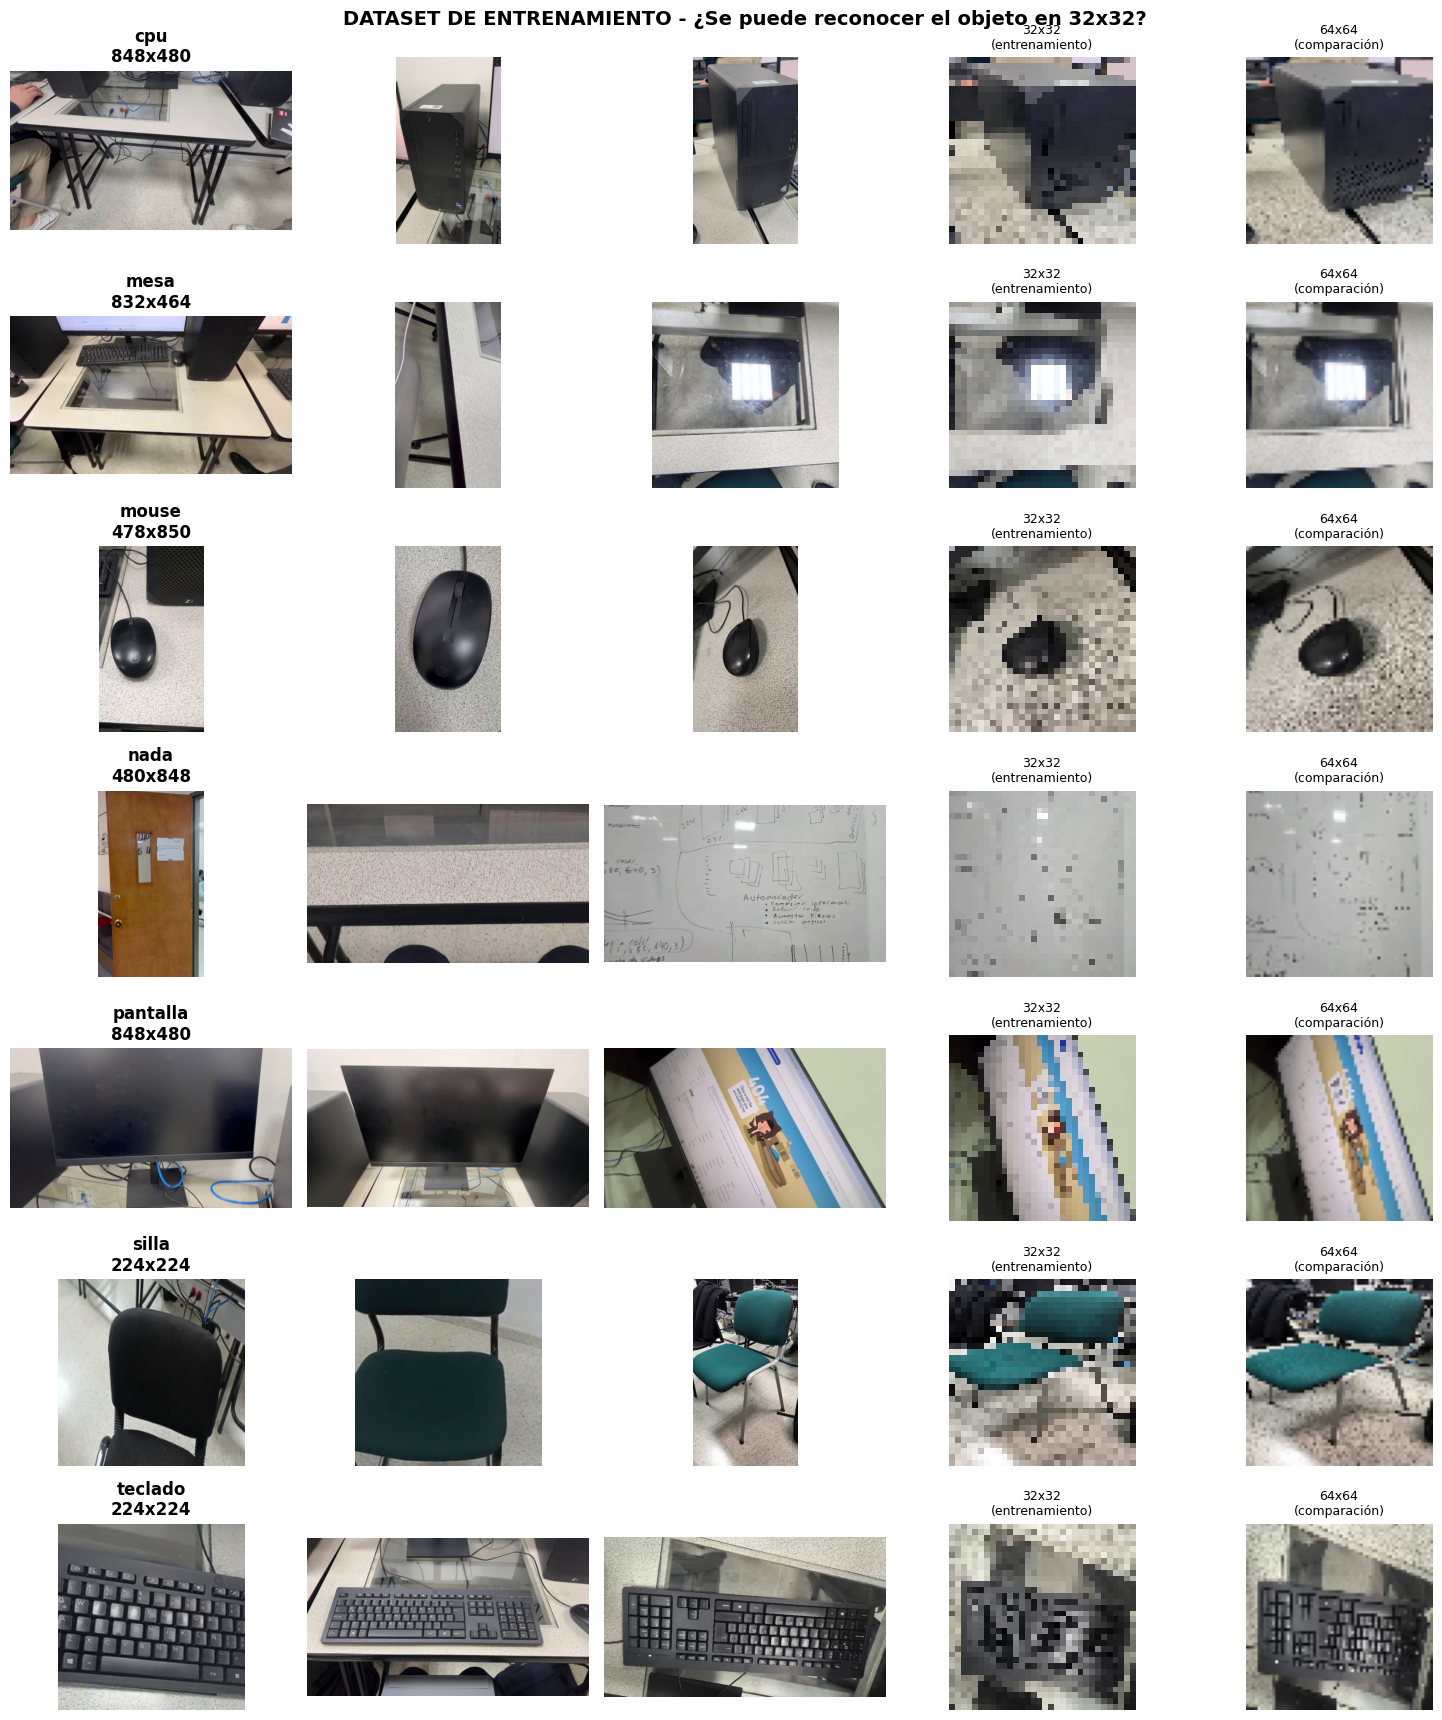

In [6]:
def visualize_training_samples(data_dir='objetos_salon/processed', samples_per_class=3):
    """
    Muestra muestras aleatorias de cada clase.
    """
    data_path = Path(data_dir)
    class_dirs = sorted([d for d in data_path.iterdir() if d.is_dir()])
    
    fig, axes = plt.subplots(len(class_dirs), samples_per_class + 2, 
                            figsize=(15, 2.5 * len(class_dirs)))
    
    for i, class_dir in enumerate(class_dirs):
        class_name = class_dir.name
        images = list(class_dir.glob('*.jpg')) + list(class_dir.glob('*.png'))
        
        # Muestras aleatorias
        samples = np.random.choice(images, min(samples_per_class, len(images)), replace=False)
        
        for j, img_path in enumerate(samples):
            img = cv2.imread(str(img_path))
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            axes[i, j].imshow(img_rgb)
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_title(f"{class_name}\n{img_rgb.shape[1]}x{img_rgb.shape[0]}", 
                                    fontweight='bold')
        
        # Mostrar cómo se ve al redimensionar a 32x32
        img_small = cv2.resize(img_rgb, (32, 32))
        axes[i, samples_per_class].imshow(img_small)
        axes[i, samples_per_class].set_title('32x32\n(entrenamiento)', fontsize=9)
        axes[i, samples_per_class].axis('off')
        
        # Mostrar cómo se ve al redimensionar a 64x64 (para comparar)
        img_medium = cv2.resize(img_rgb, (64, 64))
        axes[i, samples_per_class + 1].imshow(img_medium)
        axes[i, samples_per_class + 1].set_title('64x64\n(comparación)', fontsize=9)
        axes[i, samples_per_class + 1].axis('off')
    
    plt.suptitle('DATASET DE ENTRENAMIENTO - ¿Se puede reconocer el objeto en 32x32?', 
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

visualize_training_samples()

## 4. DIAGNÓSTICO 3: Matriz de confusión en el test set

¿Qué clases se confunden más?

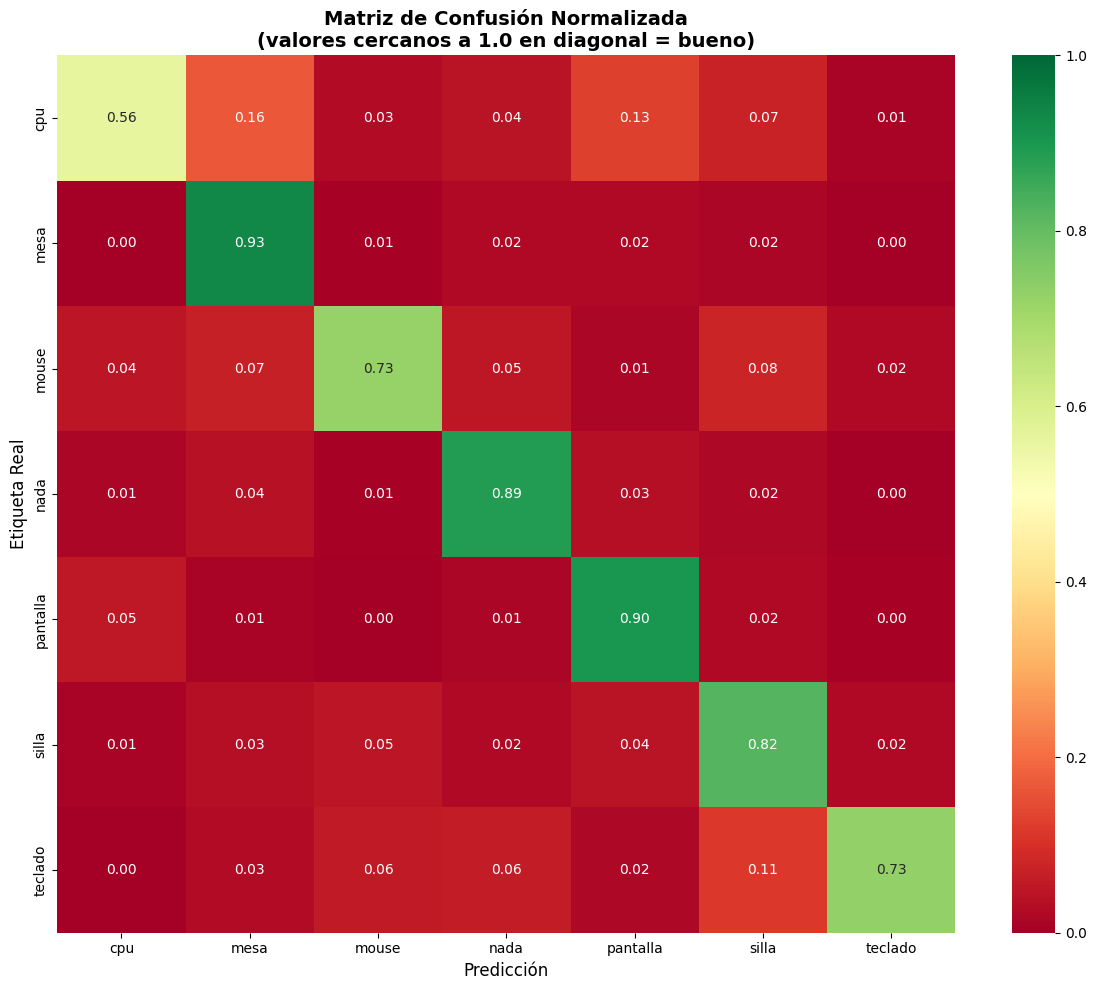


CONFUSIONES MÁS COMUNES

❌ 'cpu' se confunde con 'mesa': 16.4%
❌ 'cpu' se confunde con 'pantalla': 12.9%
❌ 'teclado' se confunde con 'silla': 11.4%

👉 SOLUCIÓN: Necesitas más imágenes que distingan estas clases



In [12]:
from torch.utils.data import DataLoader
from torchvision import datasets
from sklearn.metrics import confusion_matrix, classification_report

# Cargar test set
test_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

full_dataset = datasets.ImageFolder('objetos_salon/processed', transform=test_transform)

# Usar una muestra para evaluar
test_loader = DataLoader(full_dataset, batch_size=32, shuffle=False)

# Evaluar
all_preds = []
all_labels = []

classifier.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = classifier(images)
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

# Matriz de confusión
cm = confusion_matrix(all_labels, all_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12, 10))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', 
            xticklabels=classes, yticklabels=classes, 
            cmap='RdYlGn', vmin=0, vmax=1)
plt.xlabel('Predicción', fontsize=12)
plt.ylabel('Etiqueta Real', fontsize=12)
plt.title('Matriz de Confusión Normalizada\n(valores cercanos a 1.0 en diagonal = bueno)', 
         fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Identificar confusiones más comunes
print("\n" + "="*70)
print("CONFUSIONES MÁS COMUNES")
print("="*70 + "\n")

confusions = []
for i in range(len(classes)):
    for j in range(len(classes)):
        if i != j and cm_normalized[i, j] > 0.1:  # Más del 10% de confusión
            confusions.append((classes[i], classes[j], cm_normalized[i, j]))

confusions.sort(key=lambda x: x[2], reverse=True)

if confusions:
    for real, pred, rate in confusions:
        print(f"❌ '{real}' se confunde con '{pred}': {rate:.1%}")
    
    print("\n👉 SOLUCIÓN: Necesitas más imágenes que distingan estas clases")
else:
    print("✓ No hay confusiones significativas (>10%)")

print("\n" + "="*70)

## 5. DIAGNÓSTICO 4: Comparar tamaños de imagen

**Hipótesis**: 32x32 es muy pequeño y pierde información crítica

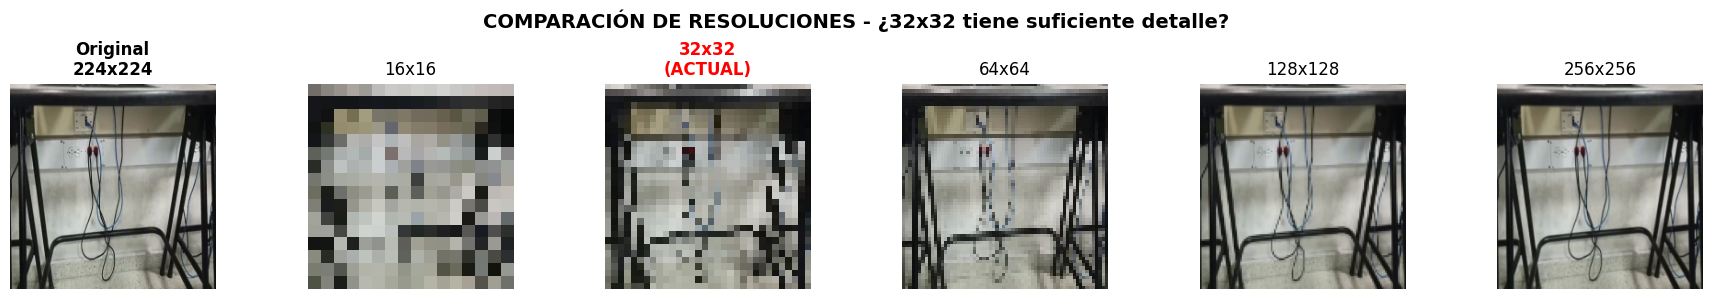


⚠️  OBSERVA: ¿Puedes reconocer el objeto en 32x32?
   Si NO, entonces el modelo tampoco puede.
   👉 SOLUCIÓN: Re-entrenar con imágenes más grandes (64x64 o 128x128)


In [13]:
def compare_image_sizes(sample_image_path):
    """
    Muestra cómo se ve una imagen en diferentes resoluciones.
    """
    img = cv2.imread(str(sample_image_path))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    sizes = [16, 32, 64, 128, 256]
    
    fig, axes = plt.subplots(1, len(sizes) + 1, figsize=(18, 3))
    
    # Original
    axes[0].imshow(img_rgb)
    axes[0].set_title(f'Original\n{img_rgb.shape[1]}x{img_rgb.shape[0]}', fontweight='bold')
    axes[0].axis('off')
    
    # Diferentes tamaños
    for i, size in enumerate(sizes):
        img_resized = cv2.resize(img_rgb, (size, size))
        axes[i+1].imshow(img_resized)
        title = f'{size}x{size}'
        if size == 32:
            title += '\n(ACTUAL)'
            axes[i+1].set_title(title, fontweight='bold', color='red')
        else:
            axes[i+1].set_title(title)
        axes[i+1].axis('off')
    
    plt.suptitle('COMPARACIÓN DE RESOLUCIONES - ¿32x32 tiene suficiente detalle?', 
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Ejecutar con una imagen de muestra
sample_images = list(Path('objetos_salon/processed').rglob('*.jpg'))
if sample_images:
    compare_image_sizes(sample_images[0])
    print("\n⚠️  OBSERVA: ¿Puedes reconocer el objeto en 32x32?")
    print("   Si NO, entonces el modelo tampoco puede.")
    print("   👉 SOLUCIÓN: Re-entrenar con imágenes más grandes (64x64 o 128x128)")

## 6. DIAGNÓSTICO 5: Simular recortes de YOLO

Crear recortes similares a los que YOLO produciría:

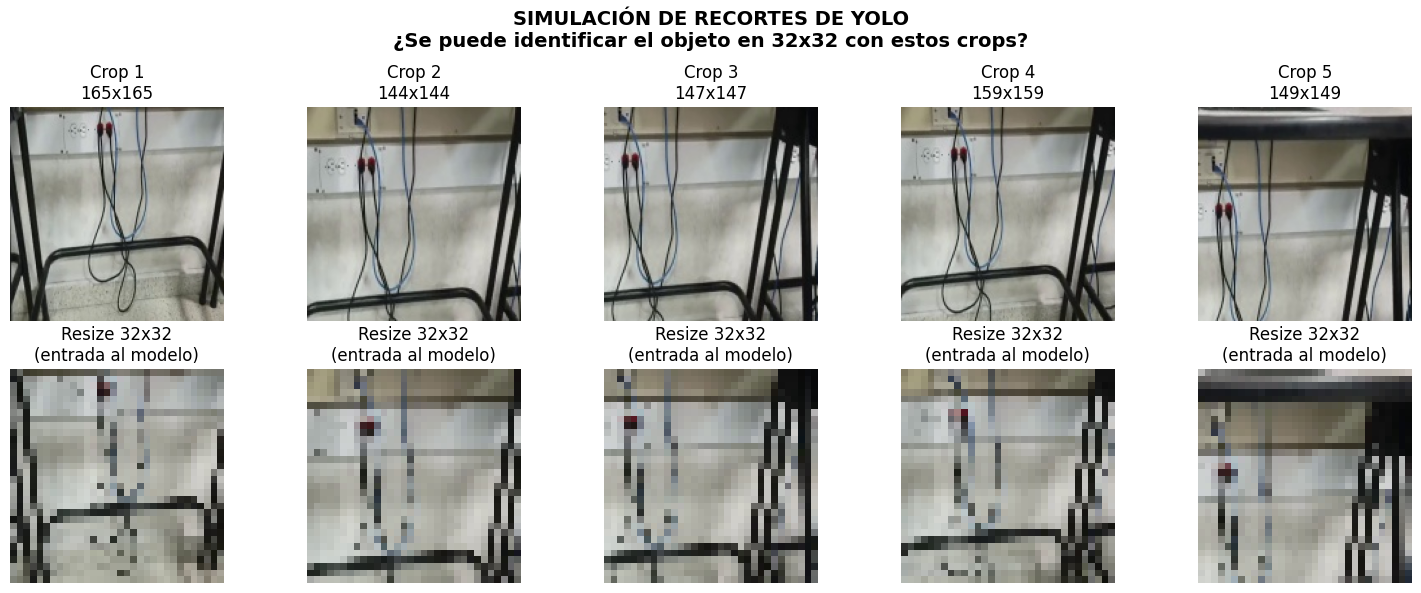


💡 OBSERVACIÓN:
   Tus imágenes de entrenamiento son perfectas (centradas, bien iluminadas)
   Pero YOLO produce recortes imperfectos (descentrados, con márgenes, etc.)
   👉 SOLUCIÓN: Necesitas DATA AUGMENTATION más agresivo en entrenamiento


In [14]:
def simulate_yolo_crops(image_path, num_crops=5):
    """
    Simula cómo YOLO podría recortar objetos (con imperfecciones).
    """
    img = cv2.imread(str(image_path))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img_rgb.shape[:2]
    
    fig, axes = plt.subplots(2, num_crops, figsize=(15, 6))
    
    for i in range(num_crops):
        # Simular recorte imperfecto
        # YOLO a veces incluye márgenes o recorta parte del objeto
        margin = np.random.uniform(-0.1, 0.1)  # ±10% de error
        
        crop_w = int(w * (0.7 + margin))
        crop_h = int(h * (0.7 + margin))
        
        x1 = np.random.randint(0, max(1, w - crop_w))
        y1 = np.random.randint(0, max(1, h - crop_h))
        x2 = min(x1 + crop_w, w)
        y2 = min(y1 + crop_h, h)
        
        crop = img_rgb[y1:y2, x1:x2]
        
        # Mostrar crop original
        axes[0, i].imshow(crop)
        axes[0, i].set_title(f'Crop {i+1}\n{crop.shape[1]}x{crop.shape[0]}')
        axes[0, i].axis('off')
        
        # Mostrar crop redimensionado a 32x32 (lo que ve el modelo)
        crop_32 = cv2.resize(crop, (32, 32))
        axes[1, i].imshow(crop_32)
        axes[1, i].set_title('Resize 32x32\n(entrada al modelo)')
        axes[1, i].axis('off')
    
    plt.suptitle('SIMULACIÓN DE RECORTES DE YOLO\n¿Se puede identificar el objeto en 32x32 con estos crops?', 
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Ejecutar simulación
if sample_images:
    simulate_yolo_crops(sample_images[0])
    print("\n💡 OBSERVACIÓN:")
    print("   Tus imágenes de entrenamiento son perfectas (centradas, bien iluminadas)")
    print("   Pero YOLO produce recortes imperfectos (descentrados, con márgenes, etc.)")
    print("   👉 SOLUCIÓN: Necesitas DATA AUGMENTATION más agresivo en entrenamiento")

## 7. RECOMENDACIONES FINALES

Basado en los diagnósticos anteriores:

In [15]:
print("\n" + "="*70)
print("📋 RECOMENDACIONES PRIORIZADAS")
print("="*70 + "\n")

print("🔴 CRÍTICO (hacer primero):")
print("""\n1. RE-ENTRENAR CON IMÁGENES MÁS GRANDES
   Problema: 32x32 es MUY pequeño, pierde detalles críticos
   Solución: Re-entrenar con 64x64 o 128x128
   Impacto: +10-15% accuracy sin capturar más imágenes
   Esfuerzo: 1-2 horas (solo cambiar config y re-entrenar)
""")

print("\n🟠 ALTA PRIORIDAD:")
print("""\n2. BALANCEAR DATASET
   Problema: Clase 'nada' tiene solo 155 imágenes vs 265 en otras
   Solución: Captura +100 imágenes de 'nada' y +35-50 de cada otra clase
   Meta: 300 imágenes por clase (2,100 total)
   Impacto: +5-8% accuracy
   Esfuerzo: 1-2 semanas de captura
""")

print("""\n3. AUMENTAR VARIABILIDAD
   Problema: Imágenes muy similares (mismo ángulo, iluminación)
   Solución al capturar:
   - Diferentes ángulos (frontal, lateral, desde arriba)
   - Diferentes distancias (cerca, lejos)
   - Diferentes iluminaciones (día, noche, ventana, lámpara)
   - Diferentes fondos
   - Oclusiones parciales (objeto tapado parcialmente)
   Impacto: +8-12% accuracy
   Esfuerzo: Al capturar las 300 imágenes, hacerlo con variabilidad
""")

print("\n🟡 MEJORAS ADICIONALES:")
print("""\n4. DATA AUGMENTATION MÁS AGRESIVO
   Problema: Recortes de YOLO son imperfectos vs dataset perfecto
   Solución: Agregar más transformaciones en entrenamiento:
   - Random crops (simular recortes de YOLO)
   - Random scaling
   - Gaussian noise
   - Random erasing (simular oclusiones)
   Impacto: +3-5% accuracy
   Esfuerzo: 30 minutos (modificar código de entrenamiento)
""")

print("""\n5. CAPTURAR ESCENAS REALES
   Problema: Todas las imágenes son individuales
   Solución: Captura ~100 imágenes de escenas con múltiples objetos
   - Recorta manualmente cada objeto
   - Agrega al dataset
   Impacto: +5-7% accuracy en producción
   Esfuerzo: 1 semana
""")

print("\n" + "="*70)
print("🎯 PLAN DE ACCIÓN RECOMENDADO")
print("="*70 + "\n")

print("""Semana 1 (mejoras rápidas sin capturar datos):
  [x] Re-entrenar con 64x64 imágenes
  [x] Mejorar data augmentation
  Resultado esperado: ~80-85% accuracy

Semana 2-3 (captura estratégica):
  [x] Balancear a 300 imgs/clase CON ALTA VARIABILIDAD
  [x] Incluir escenas reales recortadas
  Resultado esperado: ~88-92% accuracy

Semana 4 (opcional, si necesitas más):
  [ ] Llegar a 500 imgs/clase
  [ ] Experimentar con arquitecturas más grandes
  Resultado esperado: ~90-95% accuracy
""")

print("\n" + "="*70 + "\n")


📋 RECOMENDACIONES PRIORIZADAS

🔴 CRÍTICO (hacer primero):

1. RE-ENTRENAR CON IMÁGENES MÁS GRANDES
   Problema: 32x32 es MUY pequeño, pierde detalles críticos
   Solución: Re-entrenar con 64x64 o 128x128
   Impacto: +10-15% accuracy sin capturar más imágenes
   Esfuerzo: 1-2 horas (solo cambiar config y re-entrenar)


🟠 ALTA PRIORIDAD:

2. BALANCEAR DATASET
   Problema: Clase 'nada' tiene solo 155 imágenes vs 265 en otras
   Solución: Captura +100 imágenes de 'nada' y +35-50 de cada otra clase
   Meta: 300 imágenes por clase (2,100 total)
   Impacto: +5-8% accuracy
   Esfuerzo: 1-2 semanas de captura


3. AUMENTAR VARIABILIDAD
   Problema: Imágenes muy similares (mismo ángulo, iluminación)
   Solución al capturar:
   - Diferentes ángulos (frontal, lateral, desde arriba)
   - Diferentes distancias (cerca, lejos)
   - Diferentes iluminaciones (día, noche, ventana, lámpara)
   - Diferentes fondos
   - Oclusiones parciales (objeto tapado parcialmente)
   Impacto: +8-12% accuracy
   Esfuer

## 8. SIGUIENTE PASO: Generar config para re-entrenar con 64x64

Te puedo ayudar a crear una nueva versión del modelo con estas mejoras.